In [60]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
warnings.filterwarnings("ignore")


In [61]:
fraud_transactions = pd.read_csv('./datasets/creditcard-modified.csv',index_col=0)
fraud_transactions.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
43428,41505.0,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,...,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,364.19,1
49906,44261.0,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,...,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,520.12,0
29474,35484.0,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,...,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,31.00,0
276481,167123.0,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,...,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,1.50,0
278846,168473.0,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,...,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0.89,0
101565,67878.0,-0.641330,-0.057304,1.489998,-1.688131,-1.151043,0.259996,-1.391069,-2.334075,1.168644,...,-1.231634,0.257164,-0.371953,-0.038566,1.397514,-0.665947,0.031003,0.180357,100.00,0
260880,159763.0,2.023952,-0.120140,-1.086918,0.423019,-0.142901,-1.127752,0.178493,-0.303234,0.564509,...,-0.276175,-0.697708,0.335631,-0.017196,-0.324904,0.200023,-0.071566,-0.058224,16.99,0
214337,139631.0,-0.688944,1.292153,-0.564281,-1.457526,2.258333,-0.323270,1.678984,-0.104128,-1.285351,...,-0.006880,-0.171568,-0.720019,-0.419435,1.211991,0.670916,-0.103986,0.030084,8.95,0
201575,133944.0,2.119362,0.142639,-2.373337,0.541949,0.608419,-1.775564,0.955775,-0.599383,0.010420,...,0.264264,0.898266,-0.168063,0.059311,0.626949,0.729035,-0.129120,-0.094713,10.00,0
81055,58769.0,-5.584256,-4.732413,-0.448452,-0.121442,-0.707412,-0.114376,-1.554628,1.402126,-0.031693,...,0.041651,0.621789,0.223467,-0.770137,0.621182,-0.028738,0.505194,-1.898323,101.49,0


In [62]:
fraud_transactions.shape

(30000, 31)

Time variable
208534    38.099444
103015    19.016667
253345    43.391111
55687     13.074167
53929     12.837778
Name: Time_Hr, dtype: float64


Text(0, 0.5, '# transactions')

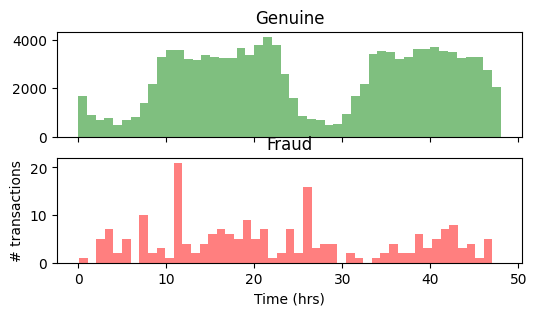

In [12]:
#plot Time to see if there is any trend
print("Time variable")
fraud_transactions["Time_Hr"] = fraud_transactions["Time"]/3600 # convert to hours
print(fraud_transactions["Time_Hr"].tail(5))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(6,3))
ax1.hist(fraud_transactions.Time_Hr[fraud_transactions.Class==0],bins=48,color='g',alpha=0.5)
ax1.set_title('Genuine')
ax2.hist(fraud_transactions.Time_Hr[fraud_transactions.Class==1],bins=48,color='r',alpha=0.5)
ax2.set_title('Fraud')
plt.xlabel('Time (hrs)')
plt.ylabel('# transactions')

In [13]:
from sklearn.preprocessing import StandardScaler
fraud_transactions = fraud_transactions.drop(['Time'],axis=1)
fraud_transactions['Amount_Scaled'] = StandardScaler().fit_transform(fraud_transactions['Amount'].values.reshape(-1,1))
fraud_transactions = fraud_transactions.drop(['Amount'],axis=1)
fraud_transactions.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Time_Hr,Amount_Scaled
43428,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,-14.110184,...,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,1,11.529167,1.163522
49906,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,-0.565012,...,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,0,12.294722,1.819760
29474,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,0.756801,...,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,0,9.856667,-0.238722
276481,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,-1.376648,...,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,0,46.423056,-0.362874
278846,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,0.259452,...,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0,46.798056,-0.365441


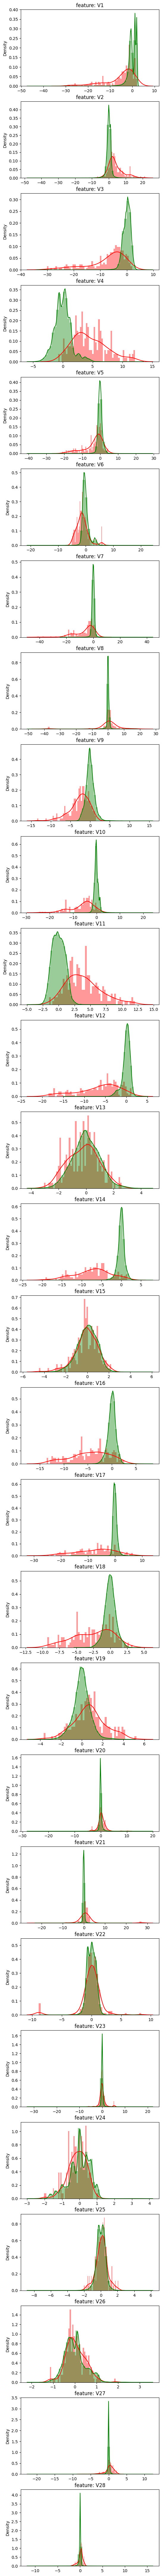

In [14]:
import seaborn as sns
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(28, 1)
plt.figure(figsize=(6,28*4))
for i, col in enumerate(fraud_transactions[fraud_transactions.iloc[:,0:28].columns]):
    ax5 = plt.subplot(gs[i])
    sns.distplot(fraud_transactions[col][fraud_transactions.Class == 1], bins=50, color='r')
    sns.distplot(fraud_transactions[col][fraud_transactions.Class == 0], bins=50, color='g')
    ax5.set_xlabel('')
    ax5.set_title('feature: ' + str(col))
plt.show()

In [11]:
import plotly.express as px
labels=["Genuine","Fraud"]

fraud_or_not = fraud_transactions["Class"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=fraud_transactions['Class'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Fraud vs Genuine transactions")
fig.show()

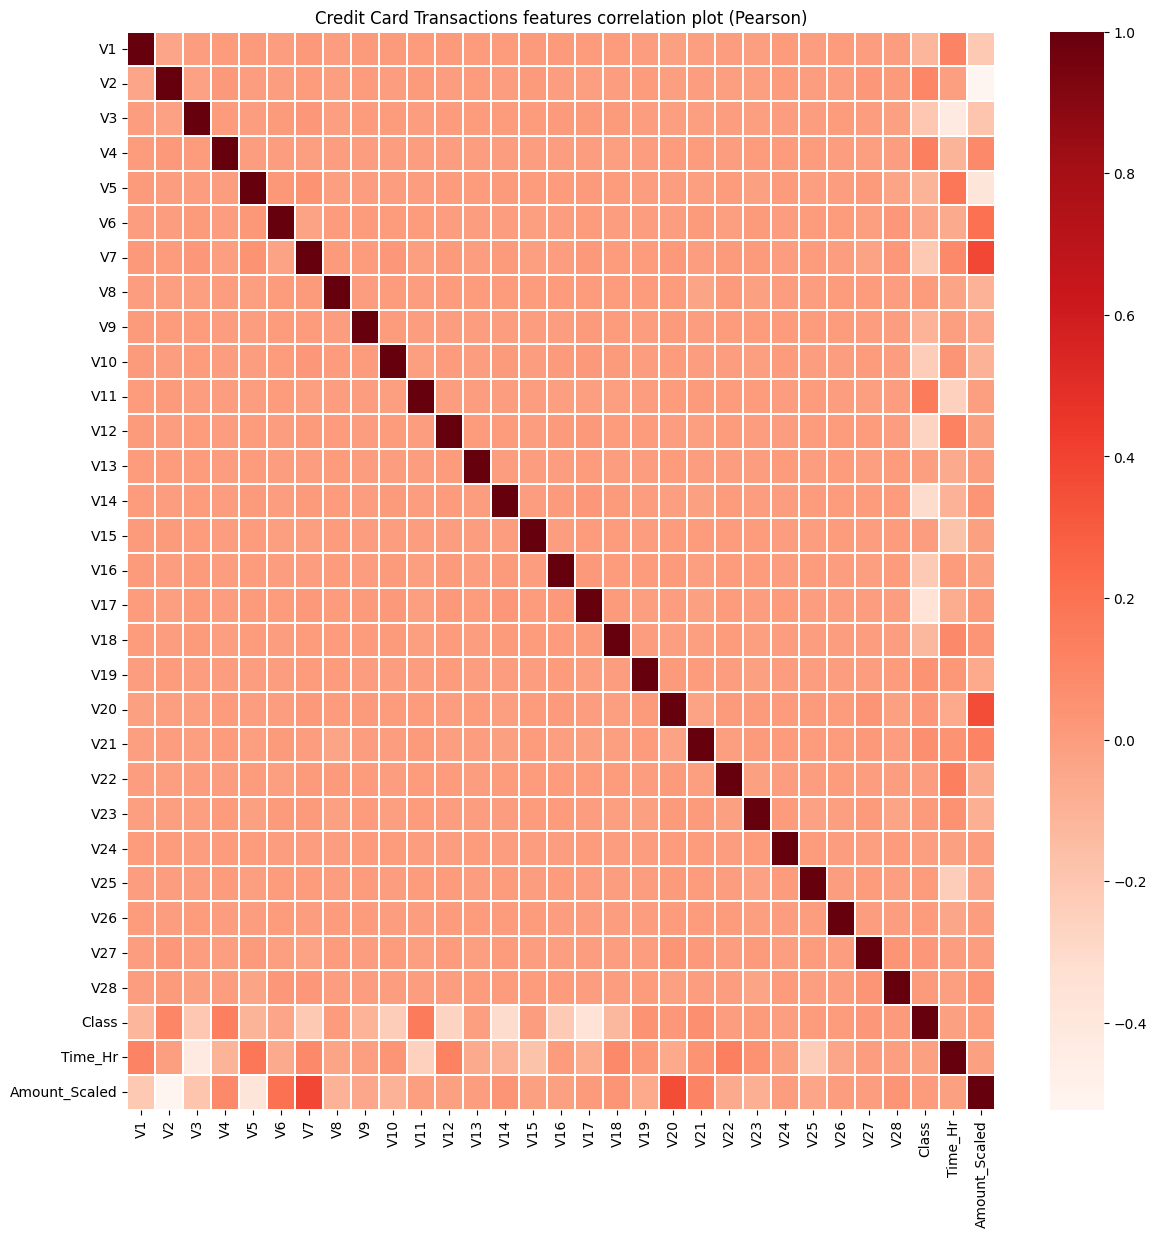

In [15]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = fraud_transactions.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

In [16]:
X = fraud_transactions.drop('Class', axis=1)
y = fraud_transactions['Class']

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

In [31]:
y_train.value_counts()

0    83855
1      145
Name: Class, dtype: int64

In [32]:
y_test.value_counts()

0    35938
1       62
Name: Class, dtype: int64

In [23]:
X_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Time_Hr,Amount_Scaled
221262,2.011239,0.073711,-1.786598,0.582587,0.038170,-1.569579,0.226018,-0.332689,0.772449,-0.487896,...,0.189883,0.613771,-0.025950,-0.059240,0.201676,-0.102199,-0.013521,-0.027486,39.583333,-0.259428
100181,1.023464,0.070625,1.359535,2.488577,-0.436688,1.128231,-0.732067,0.477043,-0.099810,0.615858,...,-0.018821,0.044725,0.006581,-0.324298,0.223442,-0.011880,0.049996,0.021785,18.734167,-0.283290
133543,-1.120137,0.546416,0.387811,-0.985015,0.163012,-1.084627,0.356352,0.482412,-0.519419,-0.526512,...,0.096003,-0.064722,-0.043402,0.014156,-0.327295,0.812373,0.126718,0.051708,22.341944,-0.243141
277475,0.112768,0.718104,-1.684662,-1.548839,3.117358,3.217262,0.370465,0.919047,-0.162223,-0.805409,...,-0.333410,-0.906450,0.117992,0.592570,-0.422615,0.164070,0.244454,0.071327,46.575833,-0.348186
194043,2.223172,-0.796640,-1.273254,-1.292398,-0.150683,-0.077139,-0.641633,-0.070280,-0.544780,0.910774,...,-0.283441,-0.905845,0.292509,-1.433177,-0.388761,-0.625948,-0.016329,-0.065385,36.227500,-0.285226


In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

#We are going to ensure that we have the same splits of the data every time. 
#We can ensure this by creating a KFold object, kf, and passing cv=kf instead of the more common cv=5.

kf = StratifiedKFold(n_splits=5, shuffle=False)
rf = RandomForestClassifier(n_estimators=100, random_state=13)
#cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall')

In [25]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))


Cross Validation Recall scores are: [0.72413793 0.72413793 0.82758621 0.68965517 0.68965517]
Average Cross Validation Recall score: 0.7310344827586207


In [26]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 10, 12],
    'random_state': [13]
}

grid_rf = GridSearchCV(rf, param_grid=params, cv=kf, 
                          scoring='recall').fit(X_train, y_train)

In [27]:
print('Best parameters:', grid_rf.best_params_)
print('Best score:', grid_rf.best_score_)

Best parameters: {'max_depth': 12, 'n_estimators': 50, 'random_state': 13}
Best score: 0.7586206896551724


In [28]:
y_pred = grid_rf.predict(X_test)

In [29]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
cm = confusion_matrix(y_test, y_pred)

rf_Recall = recall_score(y_test, y_pred)
rf_Precision = precision_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[35933     5]
 [   10    52]]


In [30]:
ndf = [(rf_Recall, rf_Precision, rf_f1, rf_accuracy)]

rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_score.insert(0, 'Random Forest with', 'No Under/Oversampling')
rf_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,No Under/Oversampling,0.83871,0.912281,0.87395,0.999583


In [33]:
fraud_transactions['Class'].value_counts()

0    119793
1       207
Name: Class, dtype: int64

In [34]:
df = fraud_transactions.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:207]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,Time_Hr,Amount_Scaled
193874,0.122910,0.635860,-0.697436,-0.234710,0.627797,-0.819152,1.060470,-0.104097,-0.182885,-0.865136,...,0.955743,-0.066317,-0.452405,-0.390145,-0.154345,0.107056,0.121344,0,36.203056,-0.041551
154839,-1.805682,-0.670727,0.125133,-0.286330,3.321070,0.581253,0.516257,0.276393,0.009190,-1.010116,...,0.497830,-0.096688,-0.701060,1.013503,0.946261,-0.137886,0.033019,0,28.677500,0.051668
58769,-0.836823,0.122819,2.688927,-0.402006,-0.743073,-0.315693,0.010180,0.370295,1.425042,-1.365815,...,-0.408551,-0.074300,0.681619,-0.180411,-0.059034,0.082548,0.121488,0,13.483056,-0.353657
223614,-0.518840,1.426787,-1.423633,-1.659366,1.709048,-0.708076,1.708753,-0.410150,0.287391,0.856861,...,0.673170,-0.429097,-1.369213,-0.061693,0.141545,0.534966,0.199740,0,39.848333,-0.365946
40120,0.504891,-1.513428,0.863825,0.556252,-1.579413,-0.012119,-0.341495,0.133409,1.271712,-0.625249,...,-0.482660,-0.131639,0.467617,-0.131264,0.919808,-0.084936,0.069976,0,11.140000,1.059950


In [36]:
new_df.shape

(414, 31)

In [37]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 1.9 s
PCA took 0.027 s
Truncated SVD took 0.01 s


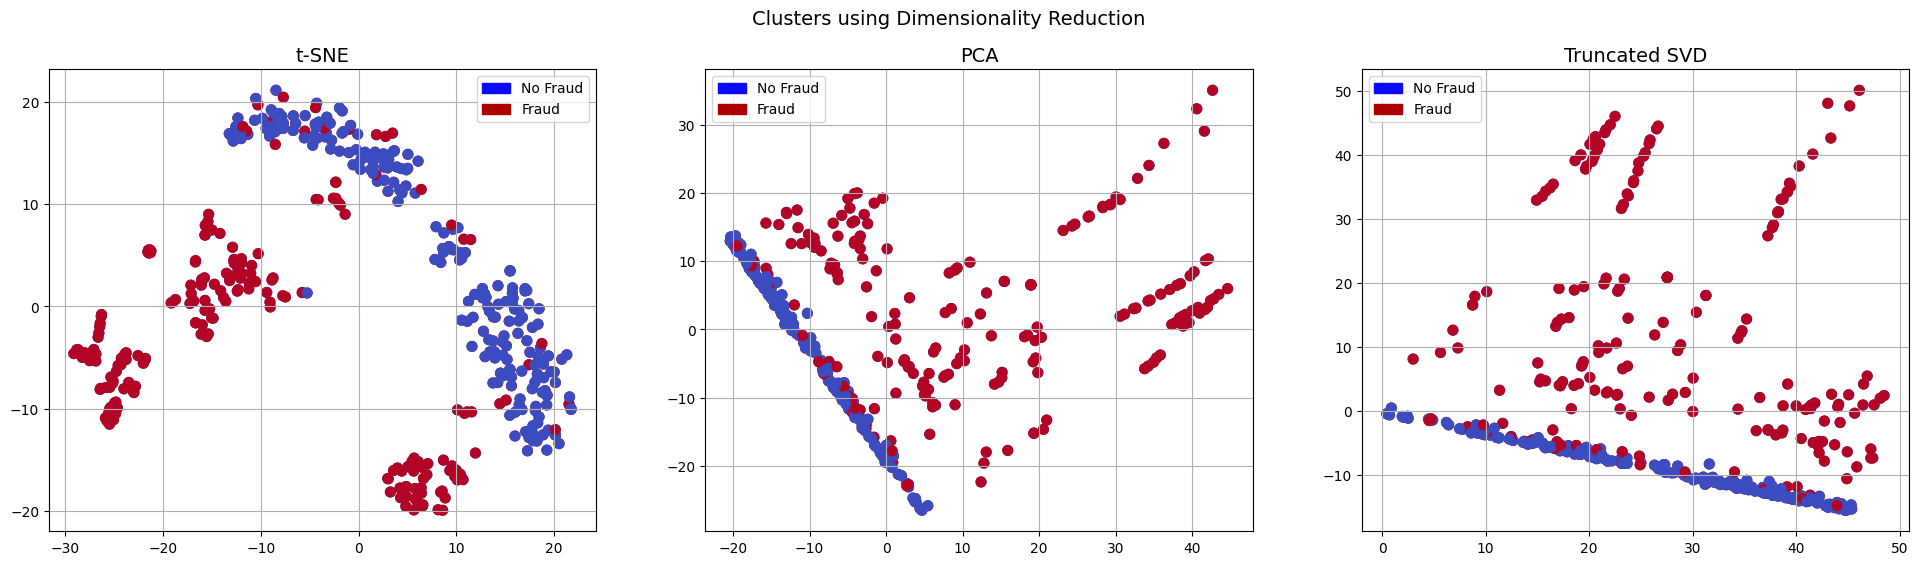

In [38]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

In [39]:
# Undersampling before cross validating (prone to overfit)
X_under = new_df.drop('Class', axis=1)
y_under = new_df['Class']

In [40]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state=42)

In [41]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [44]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "NaiveBaiyes":GaussianNB(),
    "RandomForestClassifier":RandomForestClassifier(n_estimators=50,max_depth=12,random_state=13)
}

In [45]:
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 95.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 93.0 % accuracy score
Classifiers:  SVC Has a training score of 93.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 91.0 % accuracy score
Classifiers:  GaussianNB Has a training score of 93.0 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 95.0 % accuracy score


In [49]:
# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)
tree_clf = grid_tree.best_estimator_

In [50]:
nb=GaussianNB()

In [54]:
nb.fit(X_train, y_train)

GaussianNB()

In [51]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(nb, X_train, y_train, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))


Cross Validation Recall scores are: [0.90909091 0.93939394 0.84375    0.8125     0.90625   ]
Average Cross Validation Recall score: 0.8821969696969697


In [52]:
tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

DecisionTree Classifier Cross Validation Score 94.26%


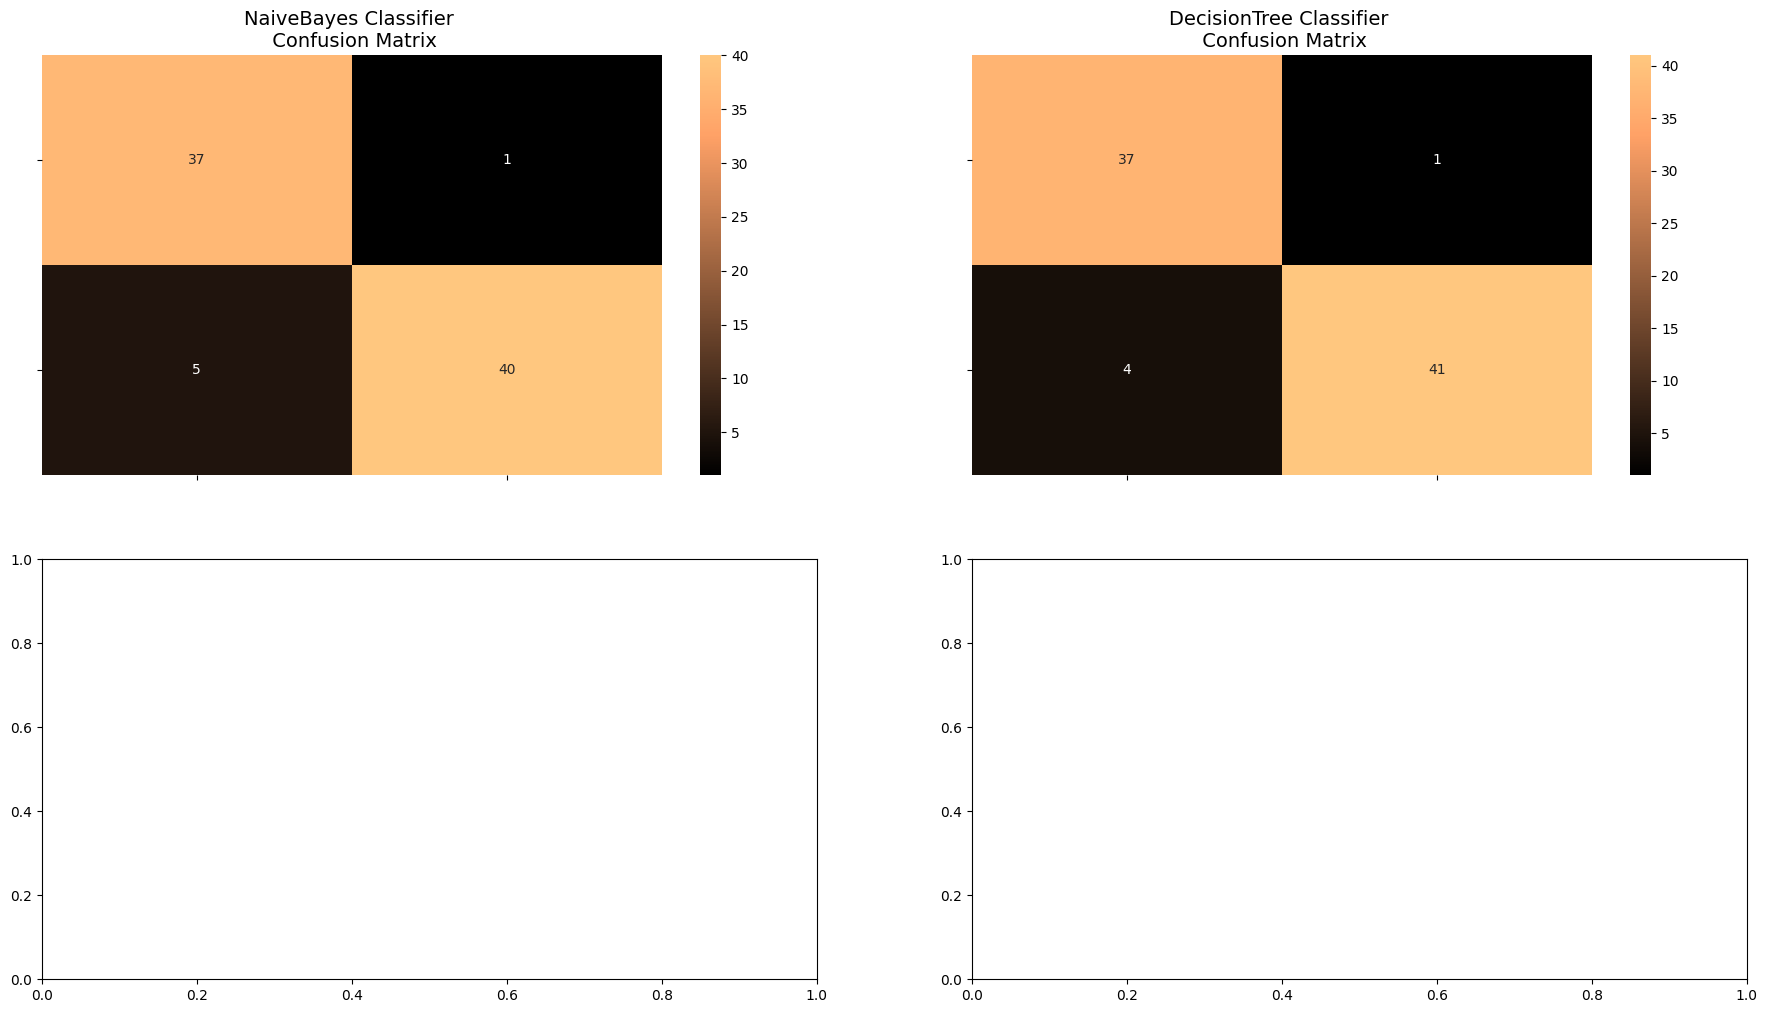

In [58]:
y_pred_nb = nb.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)


naive_cf = confusion_matrix(y_test, y_pred_nb)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(naive_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0][0].set_title("NaiveBayes Classifier \n Confusion Matrix", fontsize=14)
ax[0][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [59]:
from sklearn.metrics import classification_report


print('Naive Bayes Classifier:')
print(classification_report(y_test, y_pred_nb))

print('Decision Tree Classifier:')
print(classification_report(y_test, y_pred_tree))

Naive Bayes Classifier:
              precision    recall  f1-score   support

           0       0.88      0.97      0.93        38
           1       0.98      0.89      0.93        45

    accuracy                           0.93        83
   macro avg       0.93      0.93      0.93        83
weighted avg       0.93      0.93      0.93        83

Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.90      0.97      0.94        38
           1       0.98      0.91      0.94        45

    accuracy                           0.94        83
   macro avg       0.94      0.94      0.94        83
weighted avg       0.94      0.94      0.94        83

